# LLM Agent를 만드는 여정 (2) Tool Calling 

## 오늘의 목표 : LLM에게 도구를 쥐어주자 

이 시리즈의 두 번째 글로, LLM에게 외부의 도구들을 연동하는 방법인 `Tool Calling`을 다뤄보도록 하겠습니다.

### Setup

In [1]:
import dotenv
import os
dotenv.load_dotenv("../.env")
if not "OPENAI_API_KEY" in os.environ:
    raise Exception("OPENAI_API_KEY가 환경변수에 존재하지 않습니다.")

## LLM의 문제점: 기억의 한계

LLM은 학습한 시점의 기억만을 가지고 있습니다. LLM에게 오늘의 날짜를 물어보면, 그들은 현재 날짜가 아닌, 그들 기억 속의 날짜를 답변합니다.

In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4o-mini')

In [3]:
llm.invoke('오늘 날짜는 언제야?').content

'오늘 날짜는 2023년 10월 5일입니다.'

이렇기 때문에 LLM에게 실시간 데이터, 특정 날짜의 주식 정보등을 묻더라도, 답변을 받을 수 없습니다.

In [4]:
llm.invoke('24년 1월 첫째주 월요일 구글의 종가 정보를 가져와줘').content

'죄송하지만, 실시간 데이터나 특정 날짜의 주식 종가 정보를 제공할 수 없습니다. 하지만 구글의 주식 가격을 확인하려면 금융 뉴스 웹사이트나 주식 거래 플랫폼을 이용하시면 됩니다. Yahoo Finance, Google Finance, Bloomberg와 같은 사이트에서 원하는 날짜의 정보를 찾아보실 수 있습니다. 도움이 필요하시면 말씀해 주세요!'

그렇다면 이런 LLM이 위와 같은 질문에 답변할 수 있도록 만들려면 어떻게 해야 할까요? LLM에게 **"도구"** 를 쥐어주어야 합니다.

### 외부 도구 : Python을 통한 특정 날짜 주식 정보 조회

파이썬 패키지 중 하나인 `yfinance`는 편리하게 금융 정보를 조회할 수 있습니다. yfinance를 활용해서 주식 정보를 조회해 보도록 하겠습니다.

````shell
pip install yfinance
````

In [5]:
%%capture
# 실습에 필요해서 설치
!pip install yfinance

In [6]:
def query_stock_price(ticker:str, date: str, field: str):
    from datetime import datetime, timedelta
    import yfinance as yf
    s_date = datetime.fromisoformat(date)

    try:
        stock = yf.Ticker(ticker)
        result = stock.history(start=s_date, end=s_date + timedelta(days=1))
    except Exception as e:
        print(f"호출에 실패했습니다. e: {e}")
        return
    
    if len(result) > 0:
        value = result.iloc[0][field]
        return value
    else:
        return None

위 함수를 통해, 우리는 원하는 정보들을 가져올 수 있습니다.

In [7]:
print("2024년 4월 5일 애플 시작가    : ", query_stock_price('AAPL','2024-04-05','Open'))
print("2024년 4월 5일 구글 최고가    : ", query_stock_price('GOOGL','2024-04-05','High'))
print("2024년 4월 5일 엔비디아 종가   : ", query_stock_price('NVDA','2024-08-05','Close'))

2024년 4월 5일 애플 시작가    :  169.16447992777472
2024년 4월 5일 구글 최고가    :  153.04104728575675
2024년 4월 5일 엔비디아 종가   :  100.44140625


LLM이 위 함수를 이용할 수 있다면, 우리에게 원하는 답변을 말할 수 있지 않을까요? LLM에게 어떤 도구가 있는지를 알려주어서 해당 도구를 사용할 수 있도록 만드는 것이 바로 `Tool Calling` 입니다.

### Tool Calling: LLM이 Action을 수행하는 방법


LLM은 기본적으로 Text을 받아, Text를 반환하는 함수입니다.  LLM은 직접 함수를 실행시킬 수 있는 기능은 없습니다. 하지만 LLM은 **어떤 함수를 어떻게 호출해야 하는지를 추론할 수 있습니다.**

````mermaid
graph LR
    Task --> LLM
    
    subgraph Agent
        LLM --> Tools
        LLM --> |Reasoning| LLM
    end
    
    Environment --> |Result| Tools
    Tools --> |Action| Environment

````

LLM이 위 함수를 활용해서,아래 문장을 통해 어떤 함수를 호출하면 될지를 추론(Reasoning)하도록 만들면 됩니다.

````
INPUT  : 24년 4월 5일 구글과 시가(open) 정보를 가져와줘
OUTPUT : query_stock_price('GOOG', '2024-04-05', 'Open')
````


### Langchain Tool

Langchain에서는 LLM이 저런 함수 실행들 도와주는 `Langchain Tool`이 존재합니다. 우리는 LLM에게 우리의 함수를 이해할 수 있도록 Docstring을 추가하고, `@tool(parse_docstring=True)`을 추가합니다.

In [8]:
from langchain.tools import tool

@tool(parse_docstring=True)
def query_stock_price(ticker:str, date: str, field: str):
    """
    Retrieves the stock price for a specific ticker on a given date.

    Args:
        ticker: The stock ticker symbol (e.g., 'AAPL' for Apple Inc.).
        date: The target date in ISO format (YYYY-MM-DD).
        field: The specific price field to retrieve (e.g., 'Open', 'High', 'Low', 'Close', 'Volume').

    Returns:
        float or None: The requested stock price value if available, None otherwise.
    """    
    from datetime import datetime, timedelta
    import yfinance as yf

    s_date = datetime.fromisoformat(date)

    try:
        stock = yf.Ticker(ticker)
        result = stock.history(start=s_date, end=s_date + timedelta(days=3))
    except Exception as e:
        print(f"호출에 실패했습니다. e: {e}")
        return
    
    if len(result) > 0:
        value = result.iloc[0][field]
        return value
    else:
        return None

위와 같이 선언된 함수는 이제 LLM이 이해할 수 있는 형태로 바뀌었습니다. 아래와 같이, 해당 함수에서는 해당 코드가 어떤 동작을 하는지, 어떤 파라미터를 받는지를 알 수 있습니다.

In [9]:
print("name: ", query_stock_price.name)
print("description: ", query_stock_price.description)
print("args: \n", query_stock_price.args)

name:  query_stock_price
description:  Retrieves the stock price for a specific ticker on a given date.
args: 
 {'ticker': {'description': "The stock ticker symbol (e.g., 'AAPL' for Apple Inc.).", 'title': 'Ticker', 'type': 'string'}, 'date': {'description': 'The target date in ISO format (YYYY-MM-DD).', 'title': 'Date', 'type': 'string'}, 'field': {'description': "The specific price field to retrieve (e.g., 'Open', 'High', 'Low', 'Close', 'Volume').", 'title': 'Field', 'type': 'string'}}


그리고 LLM에게 `bind_tools`을 하여 해당 도구가 있다는 것을 알려줍니다. 

In [11]:
toolkit = [query_stock_price]
tool_llm = llm.bind_tools(toolkit)

이제 LLM에게 요청해 보겠습니다.

In [12]:
outputs = tool_llm.invoke('24년 4월 5일 구글과 애플의 시가(open) 정보를 가져와줘')

outputs

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0Fa0le72FweVUJWRQg7F1M60', 'function': {'arguments': '{"ticker": "GOOGL", "date": "2024-04-05", "field": "Open"}', 'name': 'query_stock_price'}, 'type': 'function'}, {'id': 'call_mMbEJZXlSadb2g2S3ullPwwB', 'function': {'arguments': '{"ticker": "AAPL", "date": "2024-04-05", "field": "Open"}', 'name': 'query_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 134, 'total_tokens': 209, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7713697e-e5e2-4609-a834-33133c06c307-0', tool_calls=[{'name': 'query_stock_price', 'args': {'ticker': 'GOOGL', 'date': '2024-04-05', 'field': 'Open'}, 'id': 'call_0Fa0le72FweVUJWRQg7F1M60', 'type': 'tool_call'}, {'name': 'query_stock_price', 'args': {'ticker': 'AAPL', 'dat

그러면 이전과 달리 LLM은 `content`에 응답이 오는 것이 아니라, `additional_kwargs`에 `tool_calls` 아래로 담겨 옵니다.
또한 위와 같이 여러 요청이 필요한 작업이 발생할 경우 LLM은 이렇게 N개의 요청을 나누어 제공해줍니다.

여기서 중요한 점은 LLM은 **어떤 함수를 호출해야 하는지 추론(Reasoning)만 할 뿐, 실행하진 않습니다.**  우리는 LLM의 응답을 통해 실행할 수 있도록 추가적인 작업을 더해야 합니다.

### `tool_calls`의 결과값을 실행시켜, `ToolMessage`로 변환하기

우선 LLM이 반환한 `tool_calls`은 아래와 같이 가져올 수 있습니다.

In [13]:
tool_calls = outputs.tool_calls
tool_calls

[{'name': 'query_stock_price',
  'args': {'ticker': 'GOOGL', 'date': '2024-04-05', 'field': 'Open'},
  'id': 'call_0Fa0le72FweVUJWRQg7F1M60',
  'type': 'tool_call'},
 {'name': 'query_stock_price',
  'args': {'ticker': 'AAPL', 'date': '2024-04-05', 'field': 'Open'},
  'id': 'call_mMbEJZXlSadb2g2S3ullPwwB',
  'type': 'tool_call'}]

위 응답값을 통해 우리는 아래의 요청을
> 24년 4월 5일 구글과 애플의 시가(open), 종가(close) 정보를 가져와줘

LLM은 2개의 함수 호출로 나누어 추론했음을 알수 있습니다.

````python
query_stock_price('GOOGL', '2024-04-05', 'Open')
query_stock_price('AAPL', '2024-04-05', 'Open')
````

### `tool_calls` 실행하기

위와 같이 만들어진 메시지들은 아래와 같이 호출할 수 있습니다. 

In [14]:
query_stock_price.invoke(tool_calls[0])

ToolMessage(content='149.6594212716659', name='query_stock_price', tool_call_id='call_0Fa0le72FweVUJWRQg7F1M60')

In [15]:
query_stock_price.invoke(tool_calls[1])

ToolMessage(content='169.16446466808637', name='query_stock_price', tool_call_id='call_mMbEJZXlSadb2g2S3ullPwwB')

지금은 하나의 Tool만 이용하고 있지만, 이후에 다양한 Tool들을 동시에 연동한다면, 맞는 툴을 찾아서 호출해주어야 합니다.

In [22]:
from typing import List, Dict
from langchain_core.messages.tool import ToolMessage

tool_dict =  {tool.name:tool for tool in tools}

def invoke_tool_calls(tool_calls:List[Dict]) -> List[ToolMessage]:
    """ 실제로 tool_calls을 실행시켜 message로 변환"""
    global tool_dict
    messages = []
    for tool_call in tool_calls:
        tool = tool_dict.get(tool_call['name'])            
        messages.append(tool.invoke(tool_call))
    return messages

위 코드를 통해 우리는 AI가 추론한 Tool 목록에서 맞는 툴을 찾아서 호출할 수 있습ㄴ디ㅏ.

In [25]:
tool_messages = invoke_tool_calls(tool_calls)
tool_messages

[ToolMessage(content='149.6594212716659', name='query_stock_price', tool_call_id='call_0Fa0le72FweVUJWRQg7F1M60'),
 ToolMessage(content='169.16446466808637', name='query_stock_price', tool_call_id='call_mMbEJZXlSadb2g2S3ullPwwB')]

이렇게 만들어진 Message를 다시 이전 AI 응답값과 함께 넘겨주면 AI는 처리할 수 있습니다. 이제 코드를 완성해보도록 하겠습니다.

In [26]:
from langchain.schema import HumanMessage

def answer_stock_info(question:str):
    # 1. 질문 던지기
    message = HumanMessage(content=question)
    print(f"🧑: {question}")
    chat_history = [message]
    
    # 2. ai_message가 처리하도록 추가
    while True:
        ai_message = tool_llm.invoke(chat_history)
        chat_history.append(ai_message)
        
        # 3. ai_message에서 tool_calls가 있으면 처리 후 담기
        if ai_message.tool_calls:
            print("🌐 yahoo finance를 통해 데이터 조회 중...")
            tool_messages = invoke_tool_calls(ai_message.tool_calls)
            chat_history.extend(tool_messages)
        else:
            print(f"🤖: {ai_message.content}")
            break

이렇게 작성한 프롬프트는 아래와 같이 사용할 수 있고,

In [27]:
answer_stock_info("2024년 3월달 엔비디아 종가를 알려주세요")

🧑: 2024년 3월달 엔비디아 종가를 알려주세요
🌐 yahoo finance를 통해 데이터 조회 중...


$NVDA: possibly delisted; no price data found  (1d 2024-03-29 00:00:00 -> 2024-04-01 00:00:00)


🤖: 2024년 3월 한 달간 엔비디아(NVDA)의 종가는 다음과 같습니다:

- 3월 1일: 82.26
- 3월 2일: 85.22
- 3월 3일: 85.22
- 3월 4일: 85.22
- 3월 5일: 85.95
- 3월 6일: 88.69
- 3월 7일: 92.65
- 3월 8일: 87.51
- 3월 9일: 85.76
- 3월 10일: 85.76
- 3월 11일: 85.76
- 3월 12일: 91.90
- 3월 13일: 90.87
- 3월 14일: 87.93
- 3월 15일: 87.82
- 3월 16일: 88.44
- 3월 17일: 88.44
- 3월 18일: 88.44
- 3월 19일: 89.38
- 3월 20일: 90.36
- 3월 21일: 91.42
- 3월 22일: 94.27
- 3월 23일: 94.99
- 3월 24일: 94.99
- 3월 25일: 94.99
- 3월 26일: 92.55
- 3월 27일: 90.23
- 3월 28일: 90.34
- 3월 29일: 데이터 없음
- 3월 30일: 90.35
- 3월 31일: 90.35

특정 날짜에 대한 추가 정보가 필요하시면 말씀해 주세요!


이렇게 복잡한 요청도 알아서 처리해줍니다.

In [28]:
answer_stock_info("2024년 상반기 동안 구글, 애플, 앤비디아가 이 각각 어떻게 주식 가격이 어떻게 변화했는지 수치로서 설명해 주세요")

🧑: 2024년 상반기 동안 구글, 애플, 앤비디아가 이 각각 어떻게 주식 가격이 어떻게 변화했는지 수치로서 설명해 주세요
🌐 yahoo finance를 통해 데이터 조회 중...
🤖: 2024년 상반기 동안 구글(GOOGL), 애플(AAPL), 앤비디아(NVDA)의 주식 가격 변화는 다음과 같습니다.

- **구글 (GOOGL)**
  - 2024년 1월 1일 종가: $137.83
  - 2024년 6월 30일 종가: $182.75
  - **변화**: +$44.92 (약 32.5% 상승)

- **애플 (AAPL)**
  - 2024년 1월 1일 종가: $184.94
  - 2024년 6월 30일 종가: $216.50
  - **변화**: +$31.56 (약 17.0% 상승)

- **앤비디아 (NVDA)**
  - 2024년 1월 1일 종가: $48.16
  - 2024년 6월 30일 종가: $124.29
  - **변화**: +$76.13 (약 158.2% 상승)

이 데이터를 통해 2024년 상반기 동안 각 회사의 주식이 어떻게 변화했는지 확인할 수 있습니다. 앤비디아의 주가 상승이 가장 두드러진 것을 알 수 있습니다.


## `Langgraph`을 활용하여 코드를 단순화하기

우리가 위에서 작성한 `answer_stock_info`는 `tool_calls` 요청이 생기면, 이것을 `Toolkit`을 통해 처리 후, LLM에 밀어넣는 방식으로 작성하였습니다. 

이렇게 LLM과 Tools들은 서로 상호작용하며 사람의 요청을 처리합니다. Langchain 생태계에서는 여러 컴포넌트의 상호작용을 보다 쉽게 다루기 위해 `Langgraph`라는 프레임워크를 고안했습니다. 이 코드로 어떻게 단순화시킬 수 있는지를 살펴보겠습니다.

In [37]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display

# ReAct
agent = create_react_agent(llm, tools=tools)

LLM에서 ReACT는 인공지능 언어 모델이 복잡한 질문에 답할 때 **생각(Reasoning)** 과 **행동(Acting)** 을 결합하여 더 정확하고 유용한 답변을 제공하는 기술입니다. 이는 모델이 스스로 논리적으로 추론하면서도, 필요한 경우 외부 정보나 도구를 활용하여 문제를 해결하는 방식을 말합니다. 쉽게 말해, ReACT는 AI가 사람처럼 생각하고 행동하여 더 똑똑한 답을 내놓도록 돕는 방법입니다.

LangGraph에서는 LLM과 Tool이 서로 메시지를 주고받으면서 처리할 수 있는 시스템을 미리 구성하여 제공하고 있습니다. 아래 그림에서 `__START__`가 시작되면, AGENT는 TOOLS에게 필요한 경우 메시지를 보내고, 더이상 처리할 tool_calls가 없으면 종료하는 방식으로 설계되어 있습니다.

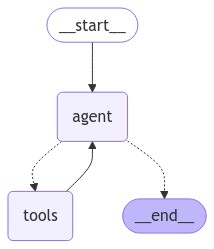

In [36]:
display(Image(agent.get_graph().draw_mermaid_png()))

Agent에 요청은 langchain처럼 `.invoke()`를 활용할 수 있습니다.

In [51]:
messages = [
    HumanMessage(content="2024년 상반기 동안 구글, 애플, 앤비디아가 이 각각 어떻게 주식 가격이 어떻게 변화했는지 수치로서 설명해 주세요")
]
inputs = {"messages": messages}

outputs = agent.invoke(inputs)

for output in outputs['messages']:
    output.pretty_print()

================================ Human Message =================================

2024년 상반기 동안 구글, 애플, 앤비디아가 이 각각 어떻게 주식 가격이 어떻게 변화했는지 수치로서 설명해 주세요
================================== Ai Message ==================================
Tool Calls:
  query_stock_price (call_66L0fjsGIJNxefCdTQeF0HIk)
 Call ID: call_66L0fjsGIJNxefCdTQeF0HIk
  Args:
    ticker: GOOGL
    date: 2024-01-01
    field: Close
  query_stock_price (call_sGfhxL5lU6iBD0UXl7yVSMrI)
 Call ID: call_sGfhxL5lU6iBD0UXl7yVSMrI
  Args:
    ticker: GOOGL
    date: 2024-06-30
    field: Close
  query_stock_price (call_NExcv3TQzGTJNHQAVThGnbB0)
 Call ID: call_NExcv3TQzGTJNHQAVThGnbB0
  Args:
    ticker: AAPL
    date: 2024-01-01
    field: Close
  query_stock_price (call_YOX9LrGR7ipQtT9wZmWkzuve)
 Call ID: call_YOX9LrGR7ipQtT9wZmWkzuve
  Args:
    ticker: AAPL
    date: 2024-06-30
    field: Close
  query_stock_price (call_SjKeoBhmFs19kEI3IVazJsF2)
 Call ID: call_SjKeoBhmFs19kEI3IVazJsF2
  Args:
    ticker: NVDA
    date: 2024-01-01

또한, 단계 별로 어떻게 처리되는지를 실시간으로 확인하려면 `.stream()` 메서드를 통해 확인할 수도 있습니다.

In [66]:
curr = 0
for state in agent.stream(inputs, stream_mode="values"):
    messages = state['messages']
    
    for message in messages[curr:]:
        message.pretty_print()
    
    curr = len(state['messages'])

================================ Human Message =================================

2024년 상반기 동안 구글, 애플, 앤비디아가 이 각각 어떻게 주식 가격이 어떻게 변화했는지 수치로서 설명해 주세요
================================== Ai Message ==================================
Tool Calls:
  query_stock_price (call_vv0XpDm4KlmnqEizq1dO4gll)
 Call ID: call_vv0XpDm4KlmnqEizq1dO4gll
  Args:
    ticker: GOOGL
    date: 2024-01-01
    field: Close
  query_stock_price (call_q1GKVjdMaXK3qknuBskxYME6)
 Call ID: call_q1GKVjdMaXK3qknuBskxYME6
  Args:
    ticker: GOOGL
    date: 2024-06-30
    field: Close
  query_stock_price (call_zWjpZ7Ja8fPeAoXHrkQUFsvU)
 Call ID: call_zWjpZ7Ja8fPeAoXHrkQUFsvU
  Args:
    ticker: AAPL
    date: 2024-01-01
    field: Close
  query_stock_price (call_u3xzwYZEdUyFcJocEEmEX2Gi)
 Call ID: call_u3xzwYZEdUyFcJocEEmEX2Gi
  Args:
    ticker: AAPL
    date: 2024-06-30
    field: Close
  query_stock_price (call_k1RbTJKWUK3RjQUEN1VFFUIy)
 Call ID: call_k1RbTJKWUK3RjQUEN1VFFUIy
  Args:
    ticker: NVDA
    date: 2024-01-01

### Reference

1. [Langchain: How to use chat models to call tools](https://python.langchain.com/docs/how_to/tool_calling/)

2. [Tool Calling for LLMs: A Detailed Tutorial](https://medium.com/@developer.yasir.pk/tool-calling-for-llms-a-detailed-tutorial-a2b4d78633e2)

3. [github issue:"An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'.](https://github.com/langchain-ai/langchain/discussions/23733)